In [8]:
# from datetime import datetime
from IPython.display import display, Markdown
from datetime import datetime, date

todays_date = str(datetime.now().date())

display(Markdown(f'# Notebook - LogReg koefficient analysis'))
display(Markdown(f'Author: Lena Erlach'))
display(Markdown(f'Created: 2024-01-25'))
display(Markdown(f'Last modified: {todays_date}'))


import numpy as np
import pandas as pd
import os, sys, configparser, random
UTILS_DIR = '/data/cb/scratch/lenae/sc_AbSpecificity_pred/src/'
sys.path.append(UTILS_DIR)
import utils_nb as utils
import matplotlib.pyplot as plt
import requests

CONFIG_PATH = '/data/cb/scratch/lenae/sc_AbSpecificity_pred/config_file_GEX_BCR.txt'

# setup parser for the config file
config = configparser.ConfigParser()
config.read(CONFIG_PATH)
ROOT_DIR = config['ROOT']['ROOT_DIR']
UTILS_DIR = config['ROOT']['UTILS_DIR']
sys.path.append(UTILS_DIR)
sys.path.append(os.path.join(UTILS_DIR))

# add the path to the Specificity_classification_class
sys.path.append('/data/cb/scratch/lenae/sc_AbSpecificity_pred/src/Spec_classification/')

import seaborn as sns
import Specificity_classification_class as CLF


# Notebook - LogReg koefficient analysis

Author: Lena Erlach

Created: 2024-01-25

Last modified: 2024-06-04

In [2]:
############# CUSTOM FUNCTIONS ####################

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Custom functions
def train_Model(model, X, y):

    # define the grid
    grid = {'clf__penalty': ['l2', None],
            'clf__class_weight': ['balanced', None],
            'clf__C': [10, 1, 0.1, 0.01, 0.001],
            'clf__max_iter': [500, 1000, 2000]
            }

    # define the pipeline
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])

    # define the metrics
    metrics = {'accuracy': accuracy_score,
            'f1': f1_score,
            'precision': precision_score,
            'recall': recall_score,
            'roc_auc': roc_auc_score,
            'matthews_corrcoef': matthews_corrcoef}

    metrics_n = list(metrics.keys())

    # define the grid search with 5-fold cross validation
    grid_search = GridSearchCV(pipe, grid, cv=5, scoring=metrics_n, refit='f1' , n_jobs=-1, verbose=0)

    # Find best parameters
    grid_search.fit(X, y)

    return grid_search


# plot ROC and the PR curve
from sklearn.metrics import precision_recall_curve,roc_curve, auc, matthews_corrcoef as MCC
from sklearn.model_selection import train_test_split


def roc_plots(X, y, best_model):

    # Assuming `X_test` is your test dataset and `model` is your trained model
    # split X into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

    trained_best_model = best_model.fit(X_train, y_train)

    # Step 1: Predict probabilities for the positive class
    y_scores = trained_best_model.predict_proba(X_test)[:, 1]

    # Step 2: Calculate precision and recall for various thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)

    # Calculate the fpr and tpr for all thresholds of the classification (ROC Curve)
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_scores)

    # Step 3: Calculate AUC for the PR curve
    auc_pr = auc(recall, precision)

    # Step 4: Plot the PR curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    # Subplot 1: Precision-Recall Curve
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_pr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')

    # Subplot 2: ROC Curve
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()



# set random seed
random.seed(123)

In [9]:
################## SETUP ##################
ab_chain = 'VDJ_VJ_aaSeq'

if ab_chain == 'VDJ_aaSeq': 
    c_type = 'VH'
elif ab_chain == 'VDJ_VJ_aaSeq':
    c_type = 'VH_VL'

datasets = ['OVA', 'RBD', 'INTEGRATED']


# number of genes to investigate
num_genes = 50

In [4]:
################## LOAD DATA - OVA ##################

dataset = datasets[0]

# dataset = 'INTEGRATED'
feat_inputPath = os.path.join(ROOT_DIR, config['BCR_GEX'][dataset])

# Load dataframe
feature_df = pd.read_csv(feat_inputPath)


# Calculate distance matrix between all sequences
distance_matrix = utils.calc_norm_levens_dist(feature_df[ab_chain],verbose=0)


#### Prepare datasets
GEX = feature_df.iloc[:, -2000:].values
kmer = feature_df.iloc[: , 6:-2000].values
GEX_kmer = feature_df.iloc[: , 6:].values
y = feature_df.loc[:, 'group_id'].values
y = [0 if i == 2 else i for i in y]
y = np.array(y)


/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

F1: 0.809 +/- 0.066
Pr: 0.808 +/- 0.129
Rec: 0.841 +/- 0.101
ROC AUC: 0.978 +/- 0.004
MCC: 0.794 +/- 0.063


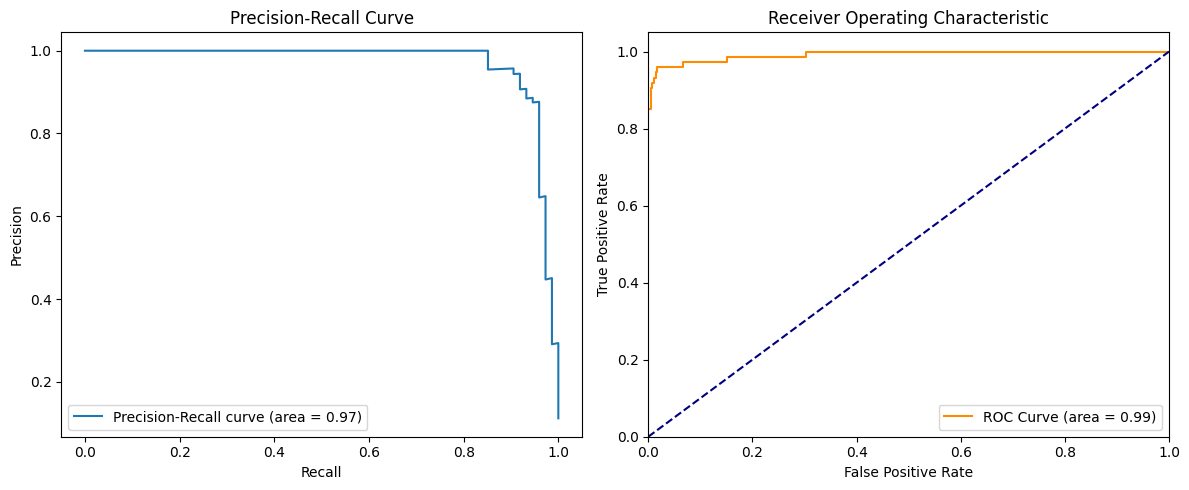

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__max_iter': 500, 'clf__penalty': 'l2'}
Best score F1: 0.88


In [5]:
####### Train model
X = GEX
# define the model
model = LogisticRegression(random_state=123)

grid_search = train_Model(model, X=X, y=y)

# best model
best_model = grid_search.best_estimator_
# get the best scores
print(f'F1: {np.mean(grid_search.cv_results_["mean_test_f1"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_f1"]):.3f}')
print(f'Pr: {np.mean(grid_search.cv_results_["mean_test_precision"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_precision"]):.3f}')
print(f'Rec: {np.mean(grid_search.cv_results_["mean_test_recall"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_recall"]):.3f}')
print(f'ROC AUC: {np.mean(grid_search.cv_results_["mean_test_roc_auc"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_roc_auc"]):.3f}')
print(f'MCC: {np.mean(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f}')

## Plot ROC curves
roc_plots(X=GEX, y=y, best_model=best_model)

# print best parameters and score
print(grid_search.best_params_)
print(f'Best score F1: {np.round(grid_search.best_score_, 4)}')

['CAPZA1' 'PABPC1' 'EEF2' 'MCM6' 'GM11808' 'CHCHD2' 'AFM' 'UBA52' 'OSBPL3'
 'HYPK' 'VCP' 'MTA2' 'ENO1B' 'GAPDH' 'EEF1A1' 'PTBP1' 'EZR' 'SH2D1B1'
 'CASP3' 'PSMD2' 'TUBA1B' 'RPA1' 'GSTP1' 'CD180' 'SLPI' 'TOX' 'CNST'
 'CD40' 'NUGGC' 'CDC25B' 'LITAF' 'STT3A' 'NONO' 'PRKCD' 'GM11683' 'UBA2'
 'ENO1' 'TAGAP' 'ANK3' 'EXOSC10' 'WDR36' 'TNFRSF8' 'TMEM123' 'RPS29'
 'MCM2' 'ELP2' 'DLGAP5' 'PRKCH' 'DCK' 'AY036118']
['GOT2' 'SLC25A5' 'CMSS1' 'EEF1G' 'APOE' 'TRIM37' 'PTGES3' 'XLR3A' 'FXN'
 'CENPX' 'MIF' 'CISD1' 'RPL14' 'GM49953' 'NPM3' 'ABR' 'NME2' 'SMARCC1'
 'HSP90AB1' 'SRSF4' 'DYNLL2' '0610010F05RIK' 'SMARCA4' 'BRCA2' 'FSCN1'
 'TYMS' 'SELENOP' 'BATF' 'SDF2L1' 'TACSTD2' 'TMPO' 'GAR1' 'PPIA' 'CBX5'
 'NXT1' 'ATP5G1' 'MARCKSL1' 'MRPL12' 'BASP1' 'GM26917' 'GSPT1' 'PGP'
 'IL31RA' 'PIM1' 'HNRNPU' 'RPS2' 'SOCS1' 'ANP32B' 'HNRNPAB' 'LMNB1']


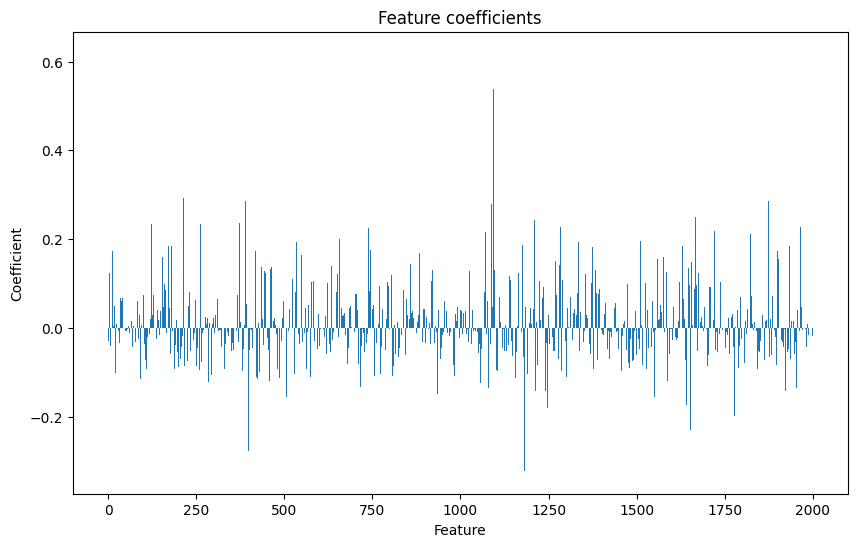

In [6]:
# summarize in dataframe 
feature_coeffs = pd.DataFrame(best_model['clf'].coef_.T, index=range(len(best_model['clf'].coef_[0])), columns=['coeff'])
feature_coeffs['gene_names'] = feature_df.columns[-2000:]

# get top and bottom genes
sorted_genes = feature_coeffs.sort_values(by='coeff', ascending=False)
pos_genes = sorted_genes[:num_genes]
neg_genes = sorted_genes[-num_genes:]

all_genes = {dataset: feature_coeffs}
gene_dict = {dataset: [pos_genes, neg_genes]}
# print top 10 up and down coefficients
print(pos_genes.gene_names.values)
print(neg_genes.gene_names.values)


# plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coeffs)), feature_coeffs['coeff'])

plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature coefficients')
plt.show()

### list of converted genes
From	To	Species	Gene Name
CD40	21939	Mus musculus	CD40 antigen(Cd40)
ENO1B	433182	Mus musculus	enolase 1B, retrotransposed(Eno1b)
ENO1	13806	Mus musculus	enolase 1, alpha non-neuron(Eno1)
LITAF	56722	Mus musculus	LPS-induced TN factor(Litaf)
PTBP1	19205	Mus musculus	polypyrimidine tract binding protein 1(Ptbp1)
CHCHD2	14004	Mus musculus	coiled-coil-helix-coiled-coil-helix domain containing 2(Chchd2)
TUBA1B	22143	Mus musculus	tubulin, alpha 1B(Tuba1b)
CNST	226744	Mus musculus	consortin, connexin sorting protein(Cnst)
CASP3	12367	Mus musculus	caspase 3(Casp3)
PSMD2	21762	Mus musculus	proteasome (prosome, macropain) 26S subunit, non-ATPase, 2(Psmd2)
TAGAP	72536	Mus musculus	T cell activation Rho GTPase activating protein(Tagap)
TNFRSF8	21941	Mus musculus	tumor necrosis factor receptor superfamily, member 8(Tnfrsf8)
DLGAP5	218977	Mus musculus	DLG associated protein 5(Dlgap5)
WDR36	225348	Mus musculus	WD repeat domain 36(Wdr36)
PRKCH	18755	Mus musculus	protein kinase C, eta(Prkch)
CD180	17079	Mus musculus	CD180 antigen(Cd180)
PRKCD	18753	Mus musculus	protein kinase C, delta(Prkcd)
ANK3	11735	Mus musculus	ankyrin 3, epithelial(Ank3)
DCK	13178	Mus musculus	deoxycytidine kinase(Dck)
CDC25B	12531	Mus musculus	cell division cycle 25B(Cdc25b)
EEF1A1	13627	Mus musculus	eukaryotic translation elongation factor 1 alpha 1(Eef1a1)
SLPI	20568	Mus musculus	secretory leukocyte peptidase inhibitor(Slpi)
MCM6	17219	Mus musculus	minichromosome maintenance complex component 6(Mcm6)
SH2D1B1	26904	Mus musculus	SH2 domain containing 1B1(Sh2d1b1)
PABPC1	18458	Mus musculus	poly(A) binding protein, cytoplasmic 1(Pabpc1)
TOX	252838	Mus musculus	thymocyte selection-associated high mobility group box(Tox)
EZR	22350	Mus musculus	ezrin(Ezr)
GAPDH	14433	Mus musculus	glyceraldehyde-3-phosphate dehydrogenase(Gapdh)
UBA52	22186	Mus musculus	ubiquitin A-52 residue ribosomal protein fusion product 1(Uba52)
MCM2	17216	Mus musculus	minichromosome maintenance complex component 2(Mcm2)
VCP	269523	Mus musculus	valosin containing protein(Vcp)
GSTP1	14870	Mus musculus	glutathione S-transferase, pi 1(Gstp1)
AFM	280662	Mus musculus	afamin(Afm)
NUGGC	100503545	Mus musculus	nuclear GTPase, germinal center associated(Nuggc)
TMEM123	71929	Mus musculus	transmembrane protein 123(Tmem123)
EXOSC10	50912	Mus musculus	exosome component 10(Exosc10)
AY036118	101056014	Mus musculus	cDNA sequence AY036118(AY036118)
MTA2	23942	Mus musculus	metastasis-associated gene family, member 2(Mta2)
GM11683	102631682	Mus musculus	predicted gene 11683(Gm11683)
OSBPL3	71720	Mus musculus	oxysterol binding protein-like 3(Osbpl3)
NONO	53610	Mus musculus	non-POU-domain-containing, octamer binding protein(Nono)
RPA1	68275	Mus musculus	replication protein A1(Rpa1)
ELP2	58523	Mus musculus	elongator acetyltransferase complex subunit 2(Elp2)
EEF2	13629	Mus musculus	eukaryotic translation elongation factor 2(Eef2)
HYPK	67693	Mus musculus	huntingtin interacting protein K(Hypk)
RPS29	20090	Mus musculus	ribosomal protein S29(Rps29)
CAPZA1	12340	Mus musculus	capping actin protein of muscle Z-line subunit alpha 1(Capza1)
STT3A	16430	Mus musculus	STT3, subunit of the oligosaccharyltransferase complex, homolog A (S. cerevisiae)(Stt3a)
UBA2	50995	Mus musculus	ubiquitin-like modifier activating enzyme 2(Uba2)

### REPEAT for RBD

In [18]:
################## LOAD DATA - RBD ##################

dataset = datasets[1]
# dataset = 'INTEGRATED'
feat_inputPath = os.path.join(ROOT_DIR, config['BCR_GEX'][dataset])

# Load dataframe
feature_df = pd.read_csv(feat_inputPath)


# Calculate distance matrix between all sequences
distance_matrix = utils.calc_norm_levens_dist(feature_df[ab_chain],verbose=0)


#### Prepare datasets
GEX = feature_df.iloc[:, -2000:].values
kmer = feature_df.iloc[: , 6:-2000].values
GEX_kmer = feature_df.iloc[: , 6:].values
y = feature_df.loc[:, 'group_id'].values
y = [0 if i == 2 else i for i in y]
y = np.array(y)


/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

F1: 0.917 +/- 0.033
Pr: 0.905 +/- 0.086
Rec: 0.939 +/- 0.042
ROC AUC: 0.993 +/- 0.002
MCC: 0.899 +/- 0.040


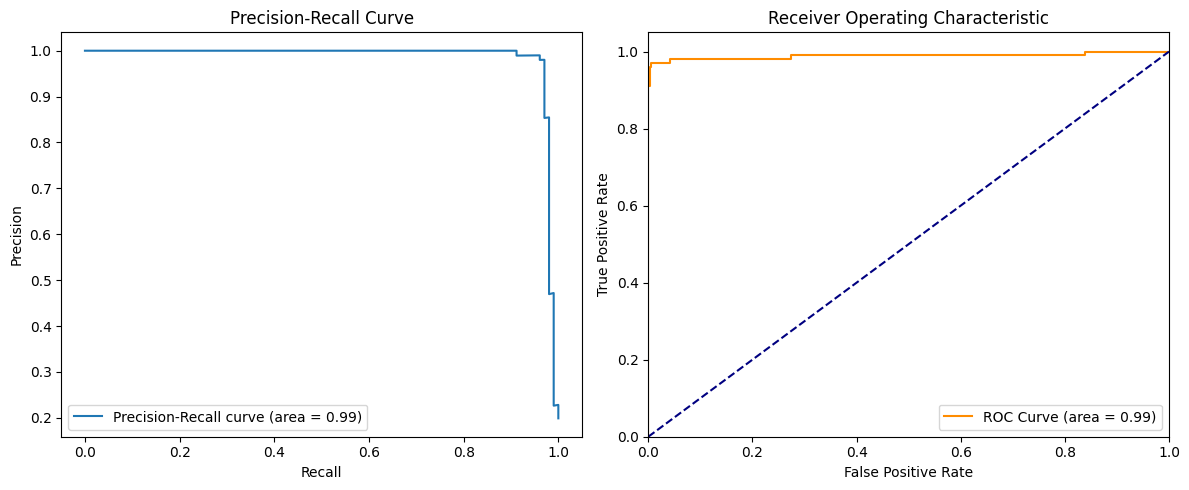

In [19]:
####### Train model
X = GEX
# define the model
model = LogisticRegression(random_state=123)

grid_search = train_Model(model, X=X, y=y)

# best model
best_model = grid_search.best_estimator_
# get the best scores
print(f'F1: {np.mean(grid_search.cv_results_["mean_test_f1"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_f1"]):.3f}')
print(f'Pr: {np.mean(grid_search.cv_results_["mean_test_precision"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_precision"]):.3f}')
print(f'Rec: {np.mean(grid_search.cv_results_["mean_test_recall"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_recall"]):.3f}')
print(f'ROC AUC: {np.mean(grid_search.cv_results_["mean_test_roc_auc"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_roc_auc"]):.3f}')
print(f'MCC: {np.mean(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f}')

## Plot ROC curves
roc_plots(X=GEX, y=y, best_model=best_model)


EIF3F,SCAND1,UBA52,RPL35,RPS28,HSPA4,RPL38,RPL37,RPS29,RPS21,RPL36,RPL41,RPL39,CHCHD2,SAC3D1,ARPP19,RPL36A,SNRPG,COX7C,RPL37A,SEC61G,RBMXL1,GM10260,GM42031,C1QBP,CMSS1,ATP5MD,TOMM7,TUBA1B,ZFP622,RRS1,NOP10,ELL3,TUBA1C,PABPC1,ATP5MPL,SLC25A4,SAP18,COX6C,GM43305,ENO1B,MICOS10,RPL31,GM46620,PGP,TUBA1A,SNRPF,ATP5K,COX17,NDUFA1
NUDC,SH2D2A,APEX1,BST2,DERL3,HDAC8,SIVA1,HSP90AA1,CDK4,UEVLD,EIF3A,TKT,YWHAE,TMA16,ORC6,STMN1,GM17057,SLC29A1,DDT,TOMM20,FTSJ3,UCHL5,PMM1,MASTL,EEF1G,ISG15,REXO2,PSMB7,RPLP0,RPL10A,TACSTD2,ARL6IP6,DUT,TMEM97,RPA2,PEBP1,GRN,ATP5B,CANX,RACK1,GAPDH,CCT4,MIF,APRT,FFAR2,SET,TAGLN2,BLVRB,HSP90AB1,GM30211


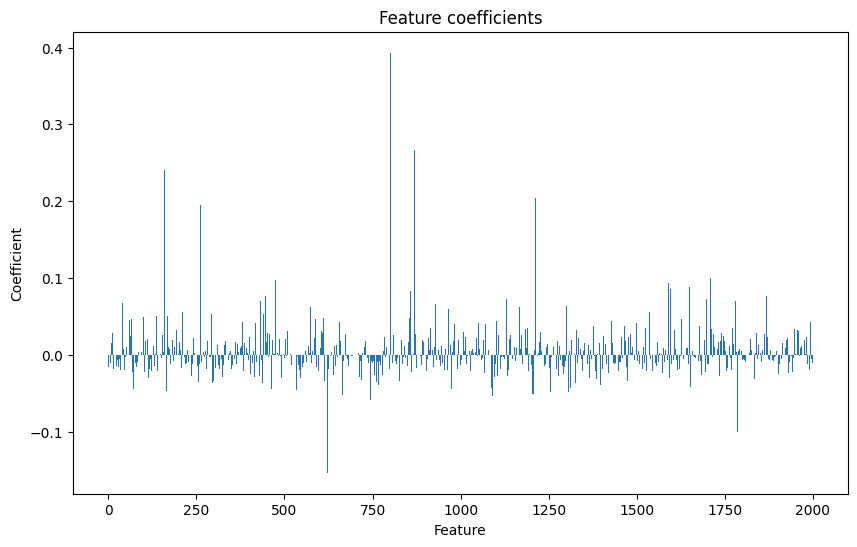

In [21]:
# summarize in dataframe 
feature_coeffs = pd.DataFrame(best_model['clf'].coef_.T, index=range(len(best_model['clf'].coef_[0])), columns=['coeff'])
feature_coeffs['gene_names'] = feature_df.columns[-2000:]

# get top and bottom 20 genes
sorted_genes = feature_coeffs.sort_values(by='coeff', ascending=False)
pos_genes = sorted_genes[:num_genes]
neg_genes = sorted_genes[-num_genes:]

gene_dict[dataset] = [pos_genes, neg_genes]
all_genes[dataset] = feature_coeffs
# print top 10 up and down coefficients
print(",".join(pos_genes.gene_names.values))
print(",".join(neg_genes.gene_names.values))


# plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coeffs)), feature_coeffs['coeff'])

plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature coefficients')
plt.show()

### INTEGRATED DATASET

In [107]:
################## LOAD DATA - INT ##################

dataset = datasets[2]

feat_inputPath = os.path.join(ROOT_DIR, config['BCR_GEX'][dataset])

# Load dataframe
feature_df = pd.read_csv(feat_inputPath)


# Calculate distance matrix between all sequences
distance_matrix = utils.calc_norm_levens_dist(feature_df[ab_chain],verbose=0)


#### Prepare datasets
GEX = feature_df.iloc[:, -2000:].values
kmer = feature_df.iloc[: , 6:-2000].values
GEX_kmer = feature_df.iloc[: , 6:].values
y = feature_df.loc[:, 'group_id'].values
y = [0 if i == 2 else i for i in y]
y = np.array(y)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

F1: 0.193 +/- 0.040
Pr: 0.172 +/- 0.007
Rec: 0.248 +/- 0.064
ROC AUC: 0.524 +/- 0.005
MCC: 0.030 +/- 0.007


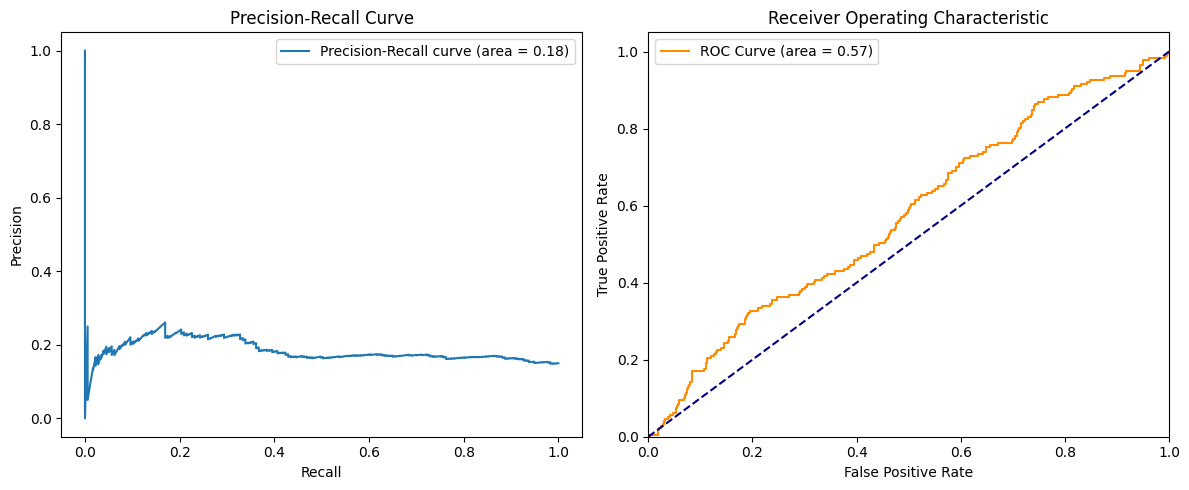

In [108]:
####### Train model
X = GEX
# define the model
model = LogisticRegression(random_state=123)

grid_search = train_Model(model, X=X, y=y)

# best model
best_model = grid_search.best_estimator_
# get the best scores
print(f'F1: {np.mean(grid_search.cv_results_["mean_test_f1"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_f1"]):.3f}')
print(f'Pr: {np.mean(grid_search.cv_results_["mean_test_precision"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_precision"]):.3f}')
print(f'Rec: {np.mean(grid_search.cv_results_["mean_test_recall"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_recall"]):.3f}')
print(f'ROC AUC: {np.mean(grid_search.cv_results_["mean_test_roc_auc"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_roc_auc"]):.3f}')
print(f'MCC: {np.mean(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f}')

## Plot ROC curves
roc_plots(X=GEX, y=y, best_model=best_model)

['RPL37' 'GM46620' 'IFI27L2A' 'RPS29' 'ASS1' 'ASPM' 'RFLNA' 'PSMD2'
 'CACNA1E' 'GM14718' 'SFN' 'PAICS' 'GM11808' 'GFRA2' 'SLAMF1' 'WFDC15A'
 'POU6F2' 'CCNB1IP1' 'MCM2' 'PDAP1' 'BUB3' 'ADAM12' 'GM17494' 'DGKH'
 'COX7C' 'LSM7' 'HOXA6' 'UBE2C' 'RASA4' 'PDZD2' 'NDC80' 'EMP2' 'HMGA1'
 'EEPD1' 'MTHFD2' 'CDC25B' 'CD68' 'TMED6' '1110038B12RIK' 'GM43623'
 'BOLA2' 'IFIT3B' 'UQCR11' 'GM15987' 'ADGRE1' 'ARHGAP11A' 'PNN' 'GM10131'
 'ANXA5' 'AY036118']
['HOXA7' 'HIST2H2BB' 'BEX3' 'TMEM97' 'PSMC3IP' 'KRT77' 'E2F8' 'GPHN'
 'SEC11C' 'GM10734' 'PAK1' 'HIGD1A' 'IFI206' 'CHAF1B' 'CDT1' 'RILPL2'
 'SERBP1' 'LMO2' 'PKMYT1' 'GM14164' 'LY6D' 'GM43305' 'CMSS1'
 'D430019H16RIK' 'TOX2' 'SDC4' 'HMCES' 'GSPT1' 'MND1' 'AARSD1' 'IQANK1'
 'HSP90AB1' 'TNFRSF9' 'GSTP1' 'NEFH' 'RUVBL2' 'CCDC175' 'S100A11' 'H13'
 'BAZ1B' 'HNRNPD' 'RERG' 'KCNJ1' 'SPAG5' 'ATAD3A' 'ATAD5' 'GM42418'
 'AC133103.1' 'HNRNPU' 'LARS2']


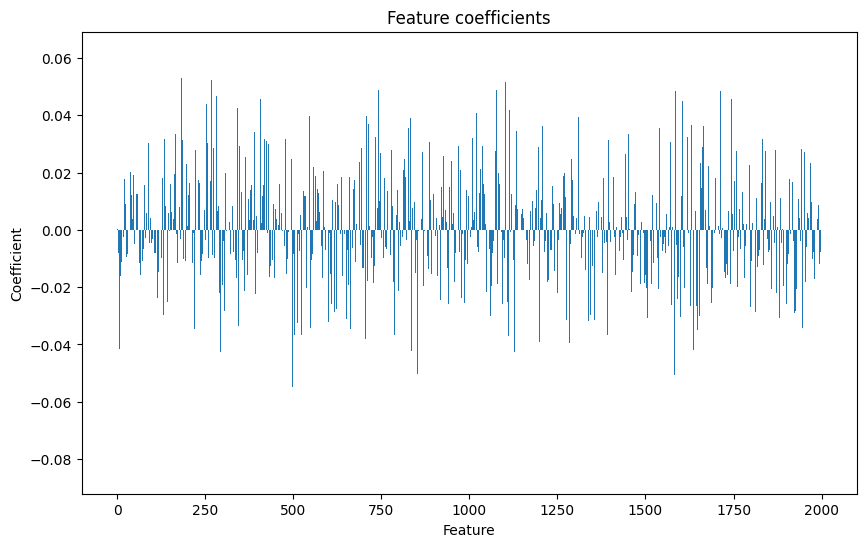

In [109]:
# summarize in dataframe 
feature_coeffs = pd.DataFrame(best_model['clf'].coef_.T, index=range(len(best_model['clf'].coef_[0])), columns=['coeff'])
feature_coeffs['gene_names'] = feature_df.columns[-2000:]

# get top and bottom 20 genes
sorted_genes = feature_coeffs.sort_values(by='coeff', ascending=False)
pos_genes = sorted_genes[:num_genes]
neg_genes = sorted_genes[-num_genes:]

gene_dict[dataset] = [pos_genes, neg_genes]
all_genes[dataset] = feature_coeffs
# print top 10 up and down coefficients
print(pos_genes.gene_names.values)
print(neg_genes.gene_names.values)


# plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coeffs)), feature_coeffs['coeff'])

plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature coefficients')
plt.show()

#### Investigate overlap of top 50 genes 

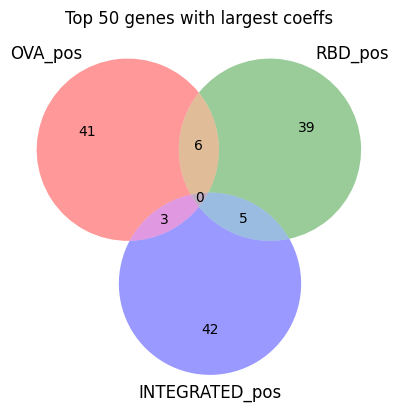

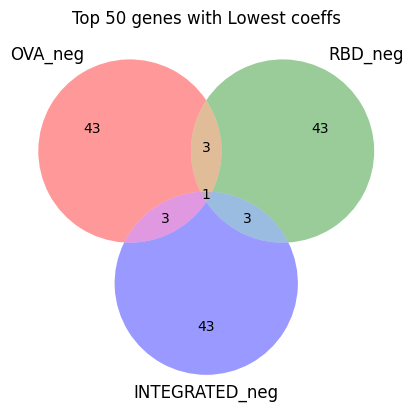

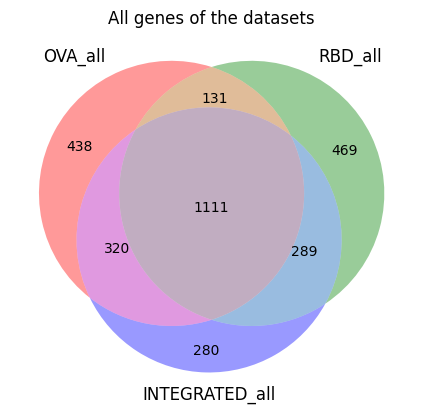

In [111]:
# venn plot of the number of genes that are in the top 25 of both datasets
from matplotlib_venn import venn2, venn3

plot_outPath = os.path.join(ROOT_DIR, 'data/model_evaluation/Specificity_classification/Plots/')

plt.figure()
venn3([set(gene_dict['OVA'][0].gene_names.values), set(gene_dict['RBD'][0].gene_names.values), set(gene_dict['INTEGRATED'][0].gene_names.values)], set_labels=('OVA_pos', 'RBD_pos', 'INTEGRATED_pos'))
plt.title(f'Top {num_genes} genes with largest coeffs')
plt.savefig(os.path.join(plot_outPath, 'venn_genes_pos.png'), dpi=600)
plt.show()

venn3([set(gene_dict['OVA'][1].gene_names.values), set(gene_dict['RBD'][1].gene_names.values), set(gene_dict['INTEGRATED'][1].gene_names.values)], set_labels=('OVA_neg', 'RBD_neg', 'INTEGRATED_neg'))
plt.title(f'Top {num_genes} genes with Lowest coeffs')
plt.savefig(os.path.join(plot_outPath, 'venn_genes_neg.png'), dpi=600)
plt.show()


### Venn plot of all genes
plt.figure()
venn3([set(all_genes['OVA'].gene_names.values), set(all_genes['RBD'].gene_names.values), set(all_genes['INTEGRATED'].gene_names.values)], set_labels=('OVA_all', 'RBD_all', 'INTEGRATED_all'))
plt.title(f'All genes of the datasets')
plt.savefig(os.path.join(plot_outPath, 'venn_all_genes.png'), dpi=600)
plt.show()


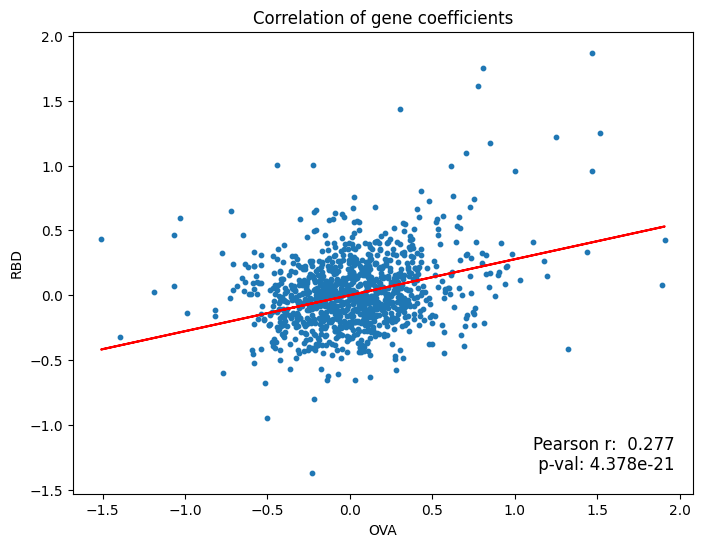

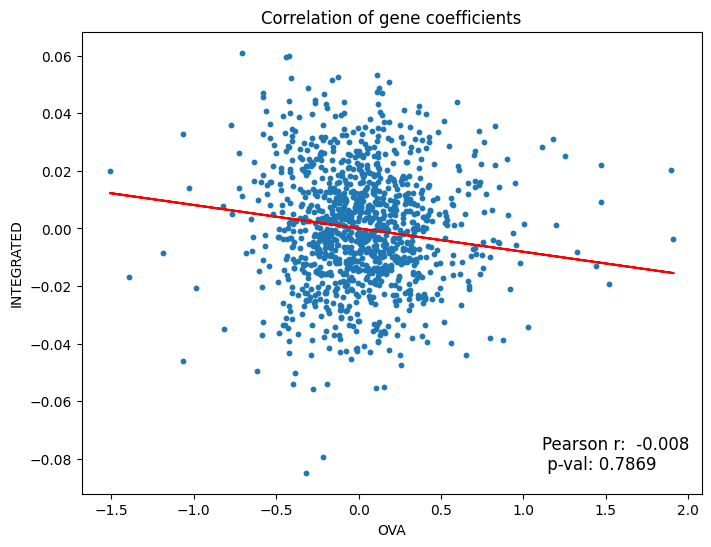

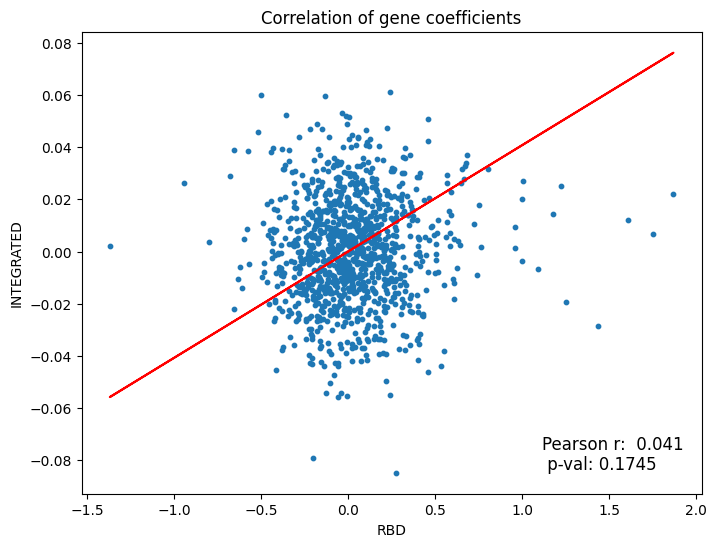

In [156]:
### plot correlation and pvalues of correlation of genes 
from scipy.stats import spearmanr, pearsonr

# get intersection of all genes
common_genes1 = np.intersect1d(all_genes['OVA'].gene_names.values, all_genes['RBD'].gene_names.values)
common_genes = np.intersect1d(common_genes1, all_genes['INTEGRATED'].gene_names.values)

# print(len(common_genes))
# print(all_genes['OVA'][all_genes['OVA'].gene_names.isin(common_genes)])
def plot_correlation(vals1, vals2, datasets=['OVA', 'RBD'], plot_outPath=None):
    # get the correlation of the genes
    correlation = pearsonr(vals1, vals2)

    # plot the correlation as scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(vals1, vals2, s=10)
    plt.xlabel(datasets[0])
    plt.ylabel(datasets[1])
    plt.title('Correlation of gene coefficients')
    # plot a line for the correlation that is a linear fit
    plt.plot(vals1, vals1*correlation[0], color='red')
    # add the correlation coefficient
    plt.text(0.7, 0.15, f'Pearson r:  {correlation[0]:.3f} \n p-val: {correlation[1]:.4}', fontsize=12, transform=plt.gcf().transFigure)

    if plot_outPath is not None:
        plt.savefig(os.path.join(plot_outPath, f'correlation_{datasets[0]}_{datasets[1]}.png'), dpi=600)
    plt.show()

# plot correlation of the genes OVA/RBD
plot_correlation(vals1=all_genes['OVA']['coeff'][all_genes['OVA'].gene_names.isin(common_genes)], vals2=all_genes['RBD']['coeff'][all_genes['RBD'].gene_names.isin(common_genes)], datasets=['OVA', 'RBD'], plot_outPath=plot_outPath)
plot_correlation(vals1=all_genes['OVA']['coeff'][all_genes['OVA'].gene_names.isin(common_genes)], vals2=all_genes['INTEGRATED']['coeff'][all_genes['INTEGRATED'].gene_names.isin(common_genes)], datasets=['OVA', 'INTEGRATED'], plot_outPath=plot_outPath)
plot_correlation(vals1=all_genes['RBD']['coeff'][all_genes['RBD'].gene_names.isin(common_genes)], vals2=all_genes['INTEGRATED']['coeff'][all_genes['INTEGRATED'].gene_names.isin(common_genes)],  datasets=['RBD', 'INTEGRATED'], plot_outPath=plot_outPath)